Imports

In [ ]:
import os
import random
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
from PIL import Image

# PyTorch / Models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Progress bar
from tqdm import tqdm

#Matlab file loading
import h5py

# Mounting dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unet model with ResNet50 encoder

In [ ]:
class AttentionDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionDecoderBlock, self).__init__()

        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()
        )

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        # Upsample the input
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)

        # Apply attention mechanism
        attention_weights = self.attention(x)
        skip = skip * attention_weights

        # Concatenate and process
        x = torch.cat([x, skip], dim=1)
        return self.conv_block(x)

class UNet_ResNet50(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super(UNet_ResNet50, self).__init__()

        # Using ResNet50 as encoder
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Modify first conv layer for single channel
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Encoder blocks
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder blocks
        self.decoder4 = self._decoder_block(2048, 1024)
        self.decoder3 = self._decoder_block(1024 + 1024, 512)
        self.decoder2 = self._decoder_block(512 + 512, 256)
        self.decoder1 = self._decoder_block(256 + 256, 64)

        # Final convolutional layer
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        # Adapt pretrained weights for single channel
        if pretrained:
            pretrained_weight = self.firstconv[0].weight.data
            self.firstconv[0].weight.data = torch.mean(pretrained_weight, dim=1, keepdim=True)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Store input size for final interpolation
        input_size = x.size()

        # Encoder path
        x1 = self.firstconv(x)
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder path with skip connections
        d4 = F.interpolate(e4, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d4 = self.decoder4(d4)
        d4 = torch.cat([d4, e3], dim=1)

        d3 = F.interpolate(d4, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d3 = self.decoder3(d3)
        d3 = torch.cat([d3, e2], dim=1)

        d2 = F.interpolate(d3, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d2 = self.decoder2(d2)
        d2 = torch.cat([d2, e1], dim=1)

        d1 = F.interpolate(d2, size=x1.shape[2:], mode='bilinear', align_corners=True)
        d1 = self.decoder1(d1)

        # Final convolution and size matching
        out = self.final_conv(d1)
        out = F.interpolate(out, size=input_size[2:], mode='bilinear', align_corners=True)

        return out

# ResNet50 Classification Model

In [ ]:
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=models.ResNet50_Weights.DEFAULT)

        # Modify first conv layer for single channel
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify final fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

        # Adapt pretrained weights for single channel
        pretrained_weight = self.model.conv1.weight.data
        adapted_weight = torch.mean(pretrained_weight, dim=1, keepdim=True)
        self.model.conv1.weight.data = adapted_weight

    def forward(self, x):
        return self.model(x)

# Data Handling and Pre-processing

In [ ]:
class AugmentedData(Dataset):
    def __init__(self, file_paths, transform=None, augment=True):
        self.file_paths = file_paths
        self.transform = transform
        self.augment = augment
        self.p = 0.5  # Probability for augmentations

        # Define transforms
        self.basic_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.456], std=[0.224])
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((224, 224),
                           interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])

    def apply_augmentation(self, image, mask):
        if random.random() < self.p:
            # Random rotation
            angle = random.uniform(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        if random.random() < self.p:
            # Random brightness
            brightness_factor = random.uniform(0.8, 1.2)
            image = TF.adjust_brightness(image, brightness_factor)

        if random.random() < self.p:
            # Random contrast
            contrast_factor = random.uniform(0.8, 1.2)
            image = TF.adjust_contrast(image, contrast_factor)

        return image, mask

    def __getitem__(self, idx):
        with h5py.File(self.file_paths[idx], 'r') as file:
            cjdata = file['cjdata']

            image = np.array(cjdata['image']).T.astype(np.float32)
            mask = np.array(cjdata['tumorMask']).T.astype(np.float32)
            label = int(cjdata['label'][0][0]) - 1  # Convert to 0-based indexing
            pid = int(cjdata['PID'][0][0])

            # Normalize image
            if image.max() > 1.0:
                image = image / image.max()

            # Convert to PIL Images
            image = Image.fromarray((image * 255).astype(np.uint8))
            mask = Image.fromarray((mask * 255).astype(np.uint8))

            # Apply augmentation if required
            if self.augment:
                image, mask = self.apply_augmentation(image, mask)

            # Convert to tensor
            image = self.basic_transform(image)
            mask = self.mask_transform(mask)

            return {
                'image': image,
                'mask': mask,
                'label': torch.tensor(label, dtype=torch.long),
                'patient_id': torch.tensor(pid, dtype=torch.long)
            }

    def __len__(self):
        return len(self.file_paths)

# Trainer

In [ ]:
# Calculate class weights for balanced learning
def calculate_class_weights(train_loader, device):
    class_counts = torch.zeros(3)
    print("Calculating class weights...")

    for batch in train_loader:
        labels = batch['label']
        for i in range(3):
            class_counts[i] += (labels == i).sum()

    # Prevent division by zero
    class_counts = torch.where(class_counts == 0, torch.ones_like(class_counts), class_counts)
    weights = 1.0 / class_counts
    weights = weights / weights.sum() * 3
    print(f"Calculated class weights: {weights}")

    return weights.to(device)

# Custom Dice Loss designed for binary segmentation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )
        return 1 - dice

class Trainer:
    def __init__(self, classification_model, segmentation_model,
                 train_loader, val_loader, test_loader, device, save_dir):
        self.classification_model = classification_model
        self.segmentation_model = segmentation_model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.save_dir = save_dir

        # Calculate class weights
        self.class_weights = calculate_class_weights(train_loader, device)

        # Enhanced loss functions
        self.class_criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        self.seg_criterion = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()

        # Optimizers with lower initial learning rate
        self.class_optimizer = torch.optim.AdamW(
            classification_model.parameters(),
            lr=5e-5,
            weight_decay=0.01
        )
        self.seg_optimizer = torch.optim.AdamW(
            segmentation_model.parameters(),
            lr=5e-5,
            weight_decay=0.01
        )

        # Modified learning rate schedulers
        self.class_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.class_optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-6
        )

        self.seg_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.seg_optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-6
        )

        # Initialize metric tracking
        self.metrics_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_dice_score': [],
            'learning_rates': []
        }

        self.best_dice = 0.0
        self.best_accuracy = 0.0

        # Create save directories
        os.makedirs(os.path.join(save_dir, 'final_results'), exist_ok=True)
        os.makedirs(os.path.join(save_dir, 'checkpoints'), exist_ok=True)

    def calculate_dice_score(self, pred, target):
        # Return dice score between 0 and 1
        with torch.no_grad():
            # Apply sigmoid to convert logits to probabilities
            pred = torch.sigmoid(pred)

            # Convert probabilities to binary predictions
            pred = (pred > 0.5).float()

            # Calculate intersection and union
            intersection = (pred * target).sum()
            union = pred.sum() + target.sum()

            # Add small epsilon to prevent division by zero
            epsilon = 1e-6

            # Dice coefficient formula: 2 * intersection / union
            dice = (2. * intersection + epsilon) / (union + epsilon)

            return dice

    def calculate_losses(self, outputs, masks, class_outputs, labels):
        if self.training:
            main_out, ds4, ds3, ds2 = outputs
            main_loss = self.seg_criterion(main_out, masks)
            ds4_loss = self.seg_criterion(ds4, masks)
            ds3_loss = self.seg_criterion(ds3, masks)
            ds2_loss = self.seg_criterion(ds2, masks)

            # Weighted combination of all segmentation losses
            seg_loss = main_loss + 0.5 * (ds4_loss + ds3_loss + ds2_loss)
        else:
            seg_loss = self.seg_criterion(outputs, masks)

        class_loss = self.class_criterion(class_outputs, labels)
        return 0.4 * class_loss + 0.6 * seg_loss

    # Saving best model
    def save_checkpoint(self, epoch, metrics, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'classification_model_state': self.classification_model.state_dict(),
            'segmentation_model_state': self.segmentation_model.state_dict(),
            'metrics': metrics
        }

        if is_best:
            best_path = os.path.join(self.save_dir, 'checkpoints', 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"\nSaved new best model with Dice score: {metrics['dice_score']:.4f}")

    # Displaying final metrics
    def display_final_metrics(self):
        print("\n=== Final Training Results ===")

        # Display final validation metrics
        print("\nValidation Performance:")
        print(f"Best Classification Accuracy: {max(self.metrics_history['val_accuracy']):.4f}")
        print(f"Best Segmentation Dice Score: {max(self.metrics_history['val_dice_score']):.4f}")
        print(f"Final Validation Loss: {self.metrics_history['val_loss'][-1]:.4f}")

        # Evaluate and display test set performance
        test_accuracy, test_dice = self.evaluate_test_set()
        print("\nTest Set Performance:")
        print(f"Classification Accuracy: {test_accuracy:.4f}")
        print(f"Segmentation Dice Score: {test_dice:.4f}")

        # Create and display learning curves, plotting training and validation loss
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.metrics_history['train_loss'], label='Train Loss')
        plt.plot(self.metrics_history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Ploting accuracy and dice score
        plt.subplot(1, 2, 2)
        plt.plot(self.metrics_history['val_accuracy'], label='Classification Accuracy')
        plt.plot(self.metrics_history['val_dice_score'], label='Dice Score')
        plt.title('Performance Metrics Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'final_results', 'learning_curves.png'))
        plt.show()

        # Save best metrics to a text file
        metrics_path = os.path.join(self.save_dir, 'final_results', 'final_metrics.txt')
        with open(metrics_path, 'w') as f:
            f.write("=== Final Training Results ===\n\n")
            f.write(f"Best Validation Accuracy: {max(self.metrics_history['val_accuracy']):.4f}\n")
            f.write(f"Best Validation Dice Score: {max(self.metrics_history['val_dice_score']):.4f}\n")
            f.write(f"Final Test Accuracy: {test_accuracy:.4f}\n")
            f.write(f"Final Test Dice Score: {test_dice:.4f}\n")

    # Training loop
    def train(self, num_epochs=10):
        print(f"\nStarting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training phase
            train_metrics = self.train_epoch()

            # Validation phase
            val_metrics = self.validate()

            # Update learning rates
            self.class_scheduler.step()
            self.seg_scheduler.step()

            # Track current learning rates
            current_lr = self.class_optimizer.param_groups[0]['lr']
            self.metrics_history['learning_rates'].append(current_lr)

            # Update metrics history
            self.metrics_history['train_loss'].append(train_metrics['loss'])
            self.metrics_history['val_loss'].append(val_metrics['loss'])
            self.metrics_history['val_accuracy'].append(val_metrics['accuracy'])
            self.metrics_history['val_dice_score'].append(val_metrics['dice_score'])

            # Print detailed epoch results
            print(f"Train Loss: {train_metrics['loss']:.4f}")
            print(f"Validation Loss: {val_metrics['loss']:.4f}")
            print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"Validation Dice Score: {val_metrics['dice_score']:.4f}")
            print(f"Current Learning Rate: {current_lr:.6f}")

            # Save best model
            if val_metrics['dice_score'] > self.best_dice:
                self.best_dice = val_metrics['dice_score']
                self.save_checkpoint(epoch, val_metrics, is_best=True)

        # Display final metrics after training is complete
        self.display_final_metrics()


    # Evaluate the model on the test set after training is complete
    def evaluate_test_set(self):

        self.classification_model.eval()
        self.segmentation_model.eval()

        test_losses = []
        test_accuracies = []
        test_dice_scores = []

        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Evaluating Test Set"):
                images = batch['image'].to(self.device)
                masks = batch['mask'].to(self.device)
                labels = batch['label'].to(self.device)

                class_outputs = self.classification_model(images)
                seg_outputs = self.segmentation_model(images)

                _, predicted = torch.max(class_outputs, 1)
                accuracy = (predicted == labels).float().mean()
                dice_score = self.calculate_dice_score(seg_outputs, masks)

                test_accuracies.append(accuracy.item())
                test_dice_scores.append(dice_score.item())

        final_accuracy = np.mean(test_accuracies)
        final_dice = np.mean(test_dice_scores)

        print("\nTest Set Results:")
        print(f"Classification Accuracy: {final_accuracy:.4f}")
        print(f"Segmentation Dice Score: {final_dice:.4f}")

        return final_accuracy, final_dice

    def train_epoch(self):
        self.classification_model.train()
        self.segmentation_model.train()

        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        dice_scores = []

        for batch in tqdm(self.train_loader, desc="Training"):
            images = batch['image'].to(self.device)
            masks = batch['mask'].to(self.device)
            labels = batch['label'].to(self.device)

            # Forward pass
            class_outputs = self.classification_model(images)
            seg_outputs = self.segmentation_model(images)

            # Calculate losses
            class_loss = self.class_criterion(class_outputs, labels)
            seg_loss = self.seg_criterion(seg_outputs, masks)
            batch_loss = class_loss + seg_loss

            # Backward pass and optimization
            self.class_optimizer.zero_grad()
            self.seg_optimizer.zero_grad()
            batch_loss.backward()
            self.class_optimizer.step()
            self.seg_optimizer.step()

            # Track metrics
            total_loss += batch_loss.item()
            _, predicted = torch.max(class_outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Calculate Dice score and move to CPU
            dice_score = self.calculate_dice_score(seg_outputs, masks)
            dice_scores.append(dice_score.cpu().item())

        # Calculate averages
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct_predictions / total_samples
        avg_dice = np.mean(dice_scores)

        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'dice_score': avg_dice
        }

    def validate(self):
      self.classification_model.eval()
      self.segmentation_model.eval()

      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      dice_scores = []
      all_preds = []
      all_labels = []

      # Initialize sample storage
      sample_images = None
      sample_masks = None
      sample_predictions = None

      with torch.no_grad():
          for i, batch in enumerate(tqdm(self.val_loader, desc="Validating")):
              images = batch['image'].to(self.device)
              masks = batch['mask'].to(self.device)
              labels = batch['label'].to(self.device)

              # Forward pass
              class_outputs = self.classification_model(images)
              seg_outputs = self.segmentation_model(images)

              # Calculate losses
              class_loss = self.class_criterion(class_outputs, labels)
              seg_loss = self.seg_criterion(seg_outputs, masks)
              batch_loss = class_loss + seg_loss

              # Track metrics
              total_loss += batch_loss.item()
              _, predicted = torch.max(class_outputs, 1)
              correct_predictions += (predicted == labels).sum().item()
              total_samples += labels.size(0)

              # Calculate Dice score
              dice_score = self.calculate_dice_score(seg_outputs, masks)
              dice_scores.append(dice_score.cpu().item())

              # Store predictions and labels for confusion matrix
              all_preds.extend(predicted.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

              # Store samples from first batch for visualization
              if i == 0:
                  sample_images = images[:4].cpu()
                  sample_masks = masks[:4].cpu()
                  sample_predictions = torch.sigmoid(seg_outputs[:4]).cpu()

      # Calculate metrics
      avg_loss = total_loss / len(self.val_loader)
      accuracy = correct_predictions / total_samples
      avg_dice = np.mean(dice_scores)
      conf_matrix = confusion_matrix(all_labels, all_preds)

      return {
          'loss': avg_loss,
          'accuracy': accuracy,
          'dice_score': avg_dice,
          'confusion_matrix': conf_matrix,
          'sample_images': sample_images,
          'sample_masks': sample_masks,
          'sample_predictions': sample_predictions
      }

# Data management

In [ ]:
def load_mat_file(file_path):
    with h5py.File(file_path, 'r') as file:
        cjdata = file['cjdata']

        # Extract image and mask data
        image = np.array(cjdata['image']).T
        mask = np.array(cjdata['tumorMask']).T
        label = int(cjdata['label'][0][0])

        # Extract PID according to the dataset structure
        pid_data = cjdata['PID']
        pid = int(''.join(map(str, np.array(pid_data).flatten())))

        return {
            'image': image,
            'mask': mask,
            'label': label,
            'patient_id': pid
        }

def load_dataset(base_path):
    file_paths = []
    class_distribution = {1: 0, 2: 0, 3: 0}  # Meningioma, Glioma, Pituitary
    patient_data = {}
    unique_pids = set()

    print("Loading dataset...")
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.mat') and file != 'cvind.mat':
                file_path = os.path.join(root, file)
                data = load_mat_file(file_path)
                pid = data['patient_id']
                label = data['label']

                unique_pids.add(pid)
                class_distribution[label] += 1

                if pid not in patient_data:
                    patient_data[pid] = {'paths': [], 'labels': set()}

                patient_data[pid]['paths'].append(file_path)
                patient_data[pid]['labels'].add(label)
                file_paths.append(file_path)

    print("\nDataset Statistics:")
    print(f"Total images: {len(file_paths)}")
    print(f"Total patients: {len(patient_data)}")
    print(f"Number of unique patients: {len(unique_pids)}")

    print("\nClass Distribution:")
    print(f"Meningioma (1): {class_distribution[1]} images")
    print(f"Glioma (2): {class_distribution[2]} images")
    print(f"Pituitary (3): {class_distribution[3]} images")

    return file_paths, patient_data

def analyze_dataset_distribution(file_paths, dataset_name="Dataset"):
    labels = []
    patient_ids = set()
    patient_slice_counts = {}

    print(f"\nAnalyzing {dataset_name}...")
    for path in tqdm(file_paths):
        data = load_mat_file(path)
        pid = data['patient_id']
        label = data['label']

        labels.append(label)
        patient_ids.add(pid)

        if pid not in patient_slice_counts:
            patient_slice_counts[pid] = 0
        patient_slice_counts[pid] += 1

    # Calculate statistics
    print(f"\n{dataset_name} Statistics:")
    print(f"Total images: {len(file_paths)}")
    print(f"Unique patients: {len(patient_ids)}")

    if patient_slice_counts:
        slices_per_patient = list(patient_slice_counts.values())
        print(f"Average slices per patient: {np.mean(slices_per_patient):.1f}")
        print(f"Min slices per patient: {min(slices_per_patient)}")
        print(f"Max slices per patient: {max(slices_per_patient)}")

    # Calculate class distribution
    if labels:
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        class_counts = {label: np.sum(labels == label) for label in unique_labels}

        print("\nClass Distribution:")
        for label in sorted(class_counts.keys()):
            count = class_counts[label]
            ratio = count / len(labels)
            print(f"Label {label}: {ratio:.3f} ({count} images)")

    return labels, list(patient_ids)

def create_data_splits(file_paths, val_ratio=0.15, test_ratio=0.15, random_state=42):

    # Get unique patient IDs
    patient_ids = []
    patient_to_files = {}

    print("Processing files to identify unique patients...")
    for path in tqdm(file_paths):
        data = load_mat_file(path)
        patient_id = data['patient_id']

        if patient_id not in patient_to_files:
            patient_to_files[patient_id] = []
        patient_to_files[patient_id].append(path)

        if patient_id not in patient_ids:
            patient_ids.append(patient_id)
    print(f"\nFound {len(patient_ids)} unique patients in the dataset")

    # Calculate split sizes
    train_size = 1.0 - (val_ratio + test_ratio)

    # Split patient IDs
    train_val_ids, test_ids = train_test_split(
        patient_ids,
        test_size=test_ratio,
        random_state=random_state
    )

    train_ids, val_ids = train_test_split(
        train_val_ids,
        test_size=val_ratio/(train_size + val_ratio),
        random_state=random_state
    )

    # Create file path lists
    train_paths = [path for pid in train_ids for path in patient_to_files[pid]]
    val_paths = [path for pid in val_ids for path in patient_to_files[pid]]
    test_paths = [path for pid in test_ids for path in patient_to_files[pid]]

    # Print split statistics
    print("\nDataset Split Statistics:")
    print(f"Training set: {len(train_paths)} images from {len(train_ids)} patients")
    print(f"Validation set: {len(val_paths)} images from {len(val_ids)} patients")
    print(f"Test set: {len(test_paths)} images from {len(test_ids)} patients")

    return train_paths, val_paths, test_paths

def create_dataloaders(train_paths, val_paths, test_paths, batch_size=16):
    train_dataset = AugmentedData(train_paths, augment=True)
    val_dataset = AugmentedData(val_paths, augment=False)
    test_dataset = AugmentedData(test_paths, augment=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Main

In [ ]:
def main():
    # Set random seeds
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    # Setup device and paths
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    DRIVE_PATH = '/content/drive/MyDrive'
    DATASET_PATH = os.path.join(DRIVE_PATH, 'CPS843_DATASET')
    SAVE_PATH = os.path.join(DRIVE_PATH, 'brain_tumor_results', datetime.now().strftime("%Y%m%d_%H%M%S")) # where the results should be stored.

    os.makedirs(SAVE_PATH, exist_ok=True)
    print(f"\nResults will be saved to: {SAVE_PATH}")

    # Load dataset and create splits
    file_paths, patient_data = load_dataset(DATASET_PATH)
    train_paths, val_paths, test_paths = create_data_splits(file_paths)

    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        train_paths,
        val_paths,
        test_paths,
        batch_size=32
    )

    # Initialize models
    segmentation_model = UNet_ResNet50(n_classes=1, pretrained=True).to(device)
    classification_model = ResNet50Classifier(num_classes=3, pretrained=True).to(device)

    # Initialize trainer
    trainer = Trainer(
        classification_model=classification_model,
        segmentation_model=segmentation_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        save_dir=SAVE_PATH
    )

    # Train models
    trainer.train(num_epochs=50)

    # Save final models
    final_checkpoint = {
        'classification_model': classification_model.state_dict(),
        'segmentation_model': segmentation_model.state_dict(),
        'training_metrics': trainer.metrics_history,
        'final_epoch': 50
    }
    torch.save(final_checkpoint,
              os.path.join(SAVE_PATH, 'final_models.pth'))

    print("\nTraining completed successfully")


# Visualizing results on test dataset
## Test dataset contains 383 images from 35 patients

Using model from: /content/drive/MyDrive/results/checkpoints/best_model.pth
Loading dataset...

Dataset Statistics:
Total images: 3064
Total patients: 233
Number of unique patients: 233

Class Distribution:
Meningioma (1): 708 images
Glioma (2): 1426 images
Pituitary (3): 930 images
Processing files to identify unique patients...


100%|██████████| 3064/3064 [00:23<00:00, 129.85it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Found 233 unique patients in the dataset

Dataset Split Statistics:
Training set: 2111 images from 163 patients
Validation set: 570 images from 35 patients
Test set: 383 images from 35 patients


<ipython-input-22-083c0a798b05>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


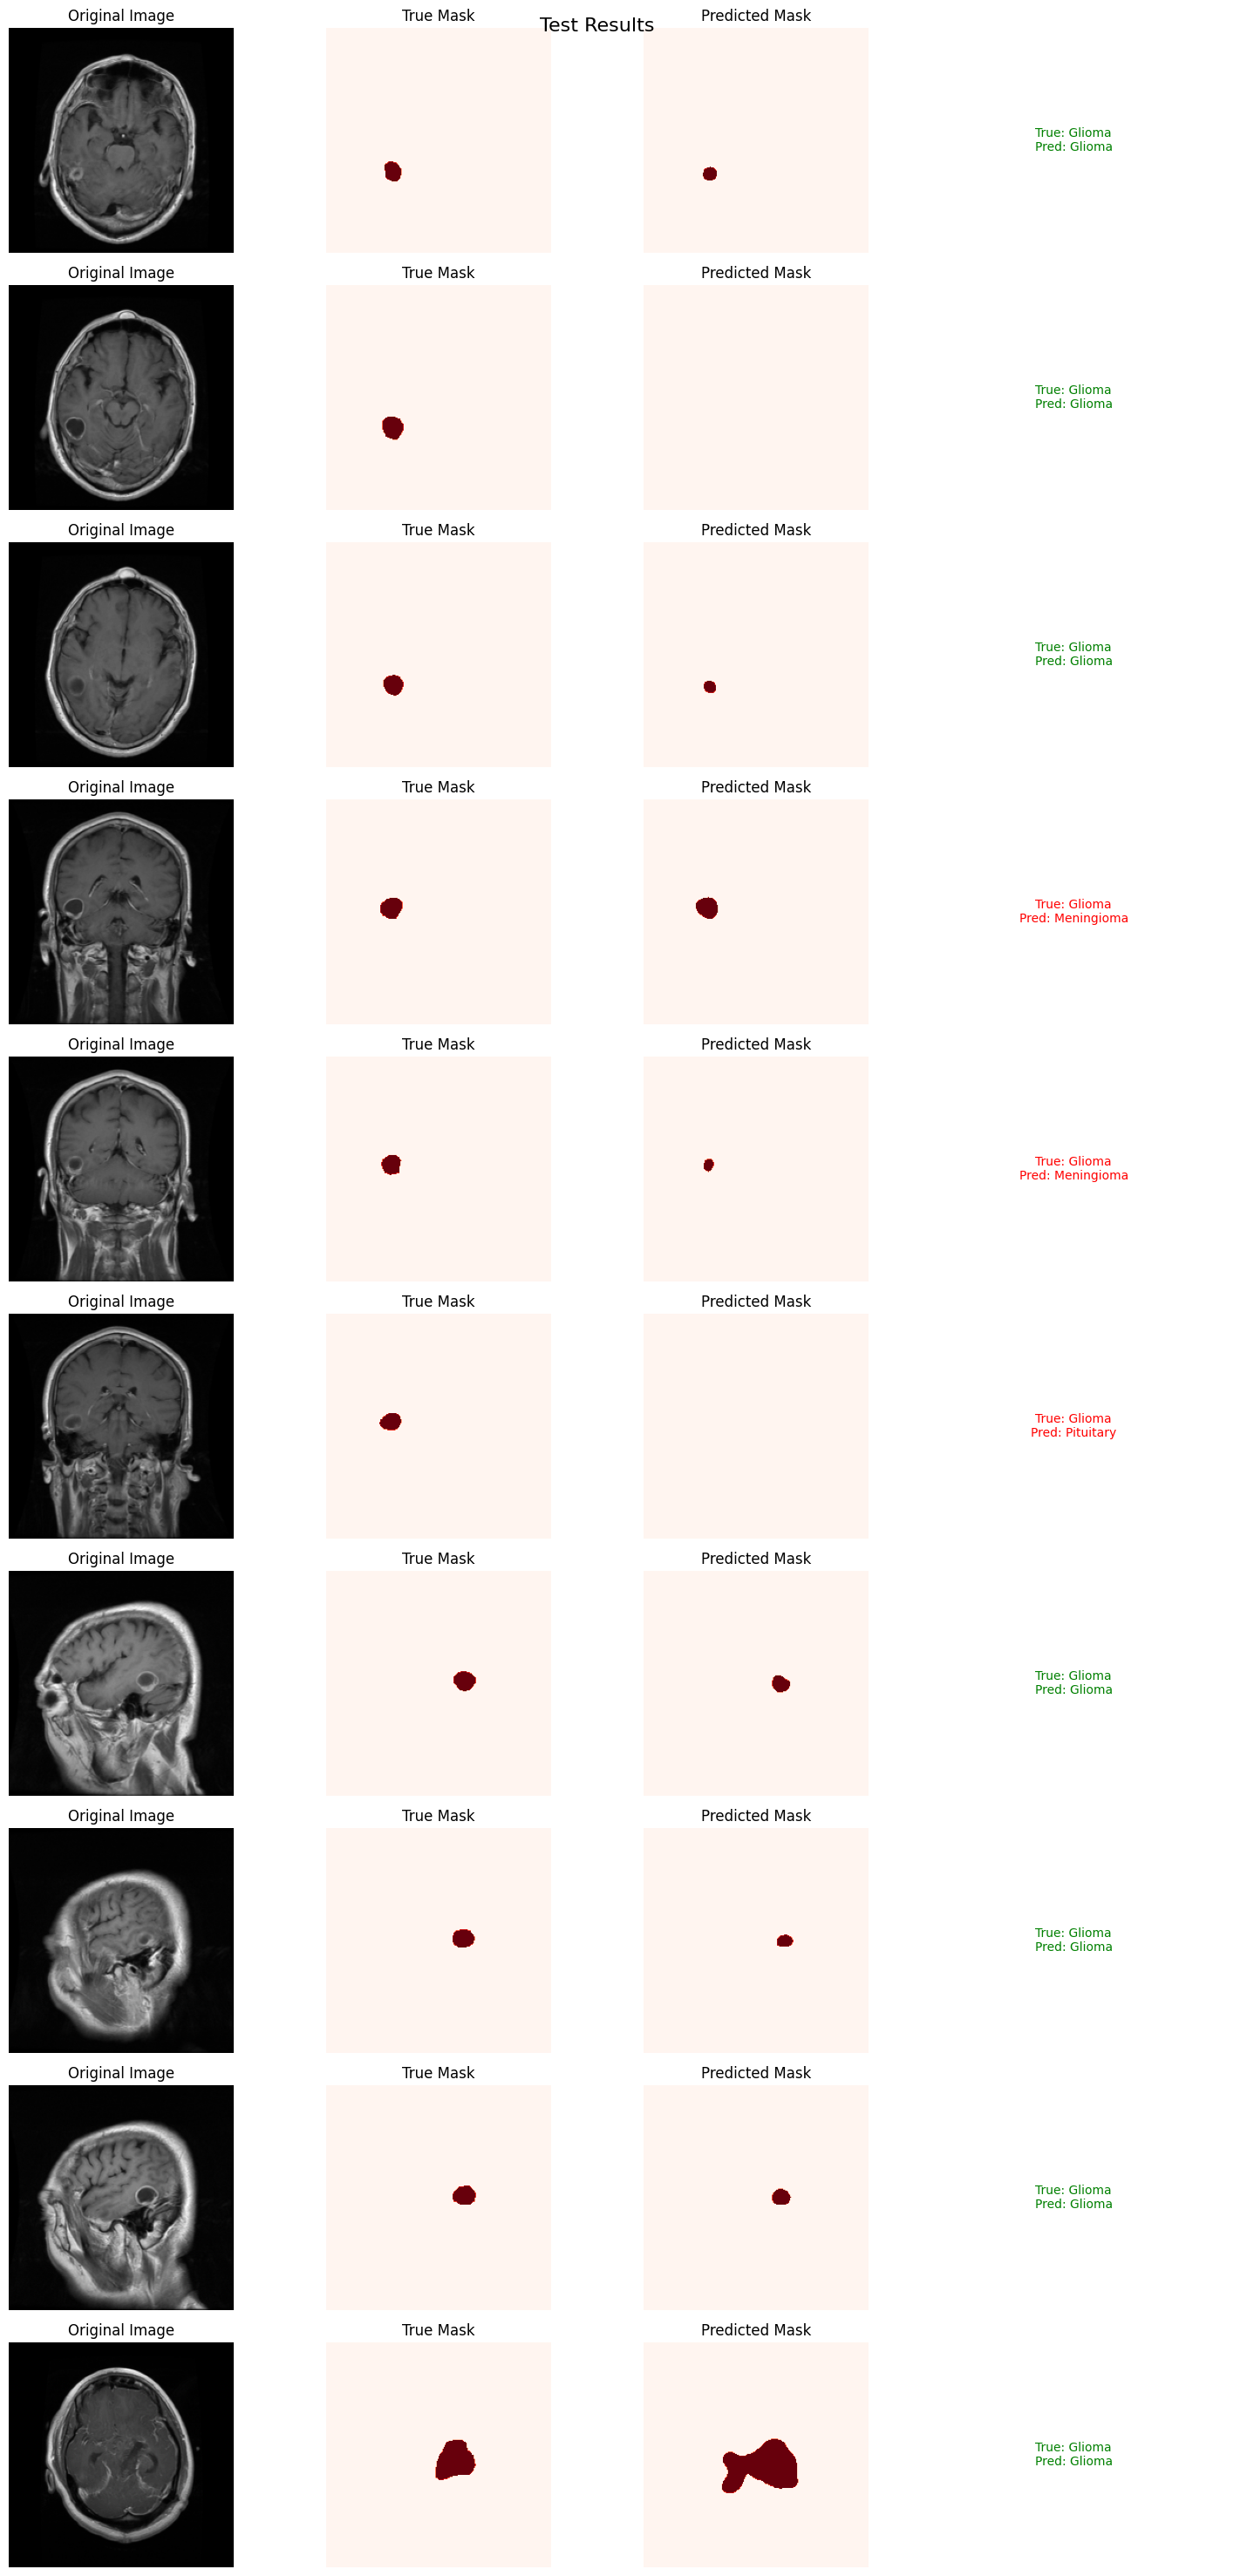


Results for visualized samples:
Classification Accuracy: 0.7000
Average Dice Score: 0.5408


In [ ]:
def visualize_test_results(model_path, test_loader, classification_model, segmentation_model, device, num_samples):
    # Load the saved models
    checkpoint = torch.load(model_path)
    classification_model.load_state_dict(checkpoint['classification_model_state'])
    segmentation_model.load_state_dict(checkpoint['segmentation_model_state'])

    # Set models to evaluation mode
    classification_model.eval()
    segmentation_model.eval()

    # Get a batch of test data
    batch = next(iter(test_loader))
    images = batch['image'].to(device)[:num_samples]
    true_masks = batch['mask'].to(device)[:num_samples]
    true_labels = batch['label'].to(device)[:num_samples]

    # Get predictions
    with torch.no_grad():
        class_outputs = classification_model(images)
        seg_outputs = segmentation_model(images)

    # Convert predictions to numpy arrays
    pred_masks = torch.sigmoid(seg_outputs).cpu().numpy()
    pred_masks = (pred_masks > 0.5).astype(np.float32)
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()

    # Get predicted labels
    _, predicted_labels = torch.max(class_outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    true_labels = true_labels.cpu().numpy()

    # Create a mapping for class labels
    class_mapping = {0: 'Meningioma', 1: 'Glioma', 2: 'Pituitary'}

    # Create the visualization
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 3*num_samples))
    fig.suptitle('Test Results', fontsize=16)

    for idx in range(num_samples):
        # Original image
        axes[idx, 0].imshow(images[idx, 0], cmap='gray')
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        # True mask
        axes[idx, 1].imshow(true_masks[idx, 0], cmap='Reds')
        axes[idx, 1].set_title('True Mask')
        axes[idx, 1].axis('off')

        # Predicted mask
        axes[idx, 2].imshow(pred_masks[idx, 0], cmap='Reds')
        axes[idx, 2].set_title('Predicted Mask')
        axes[idx, 2].axis('off')

        # Labels comparison
        axes[idx, 3].text(0.5, 0.5,
                         f'True: {class_mapping[true_labels[idx]]}\nPred: {class_mapping[predicted_labels[idx]]}',
                         ha='center', va='center',
                         color='green' if true_labels[idx] == predicted_labels[idx] else 'red',
                         fontsize=10)
        axes[idx, 3].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    accuracy = np.mean(predicted_labels == true_labels)
    dice_scores = []

    for i in range(num_samples):
        intersection = np.sum(pred_masks[i] * true_masks[i])
        union = np.sum(pred_masks[i]) + np.sum(true_masks[i])
        dice = 2 * intersection / (union + 1e-6)
        dice_scores.append(dice)

    avg_dice = np.mean(dice_scores)

    print(f"\nResults for visualized samples:")
    print(f"Classification Accuracy: {accuracy:.4f}")
    print(f"Average Dice Score: {avg_dice:.4f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/results/checkpoints/best_model.pth' # Results file provided called 'results'. Path to the best model
print(f"Using model from: {model_path}")

DRIVE_PATH = '/content/drive/MyDrive'
DATASET_PATH = os.path.join(DRIVE_PATH, 'CPS843_DATASET') # Dataset location in google drive

# Loading the dataset
file_paths, patient_data = load_dataset(DATASET_PATH)
train_paths, val_paths, test_paths = create_data_splits(file_paths)

# Loading the test dataset
test_dataset = AugmentedData(test_paths, augment=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initializing models
classification_model = ResNet50Classifier(num_classes=3, pretrained=True).to(device)
segmentation_model = UNet_ResNet50(n_classes=1, pretrained=True).to(device)

# Visualization
visualize_test_results(
    model_path=model_path,
    test_loader=test_loader,
    classification_model=classification_model,
    segmentation_model=segmentation_model,
    device=device,
    num_samples = 10 # You can change number of samples you want to see below here
)